# Monocle3

2025-07-22

## Import required libraries

In [2]:
library(Seurat)
library(tidyverse)
library(monocle3)

Loading required package: SeuratObject

Loading required package: sp




Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:SeuratObject’:

   

## Configure output directory

In [3]:
OUT = "./monocle-outputs"
if (!dir.exists(OUT)) { dir.create(OUT, recursive = TRUE) }

## Trajectory analysis using monocle3

Here, we describe a brief trajectory analysis of T cell subset using monocle3.
The dataset has various celltypes including T cell.

In [4]:
seurat <- readRDS("/BiO/data/HLCA_pulmonary_fibrosis_immune.rds")
seurat

An object of class Seurat 
19354 features across 7782 samples within 1 assay 
Active assay: RNA (19354 features, 0 variable features)
 3 layers present: counts, data, scale.data
 4 dimensional reductions calculated: pca, umap, harmony, umap.harmony

In [5]:
options(repr.plot.width = 7, repr.plot.height = 7)

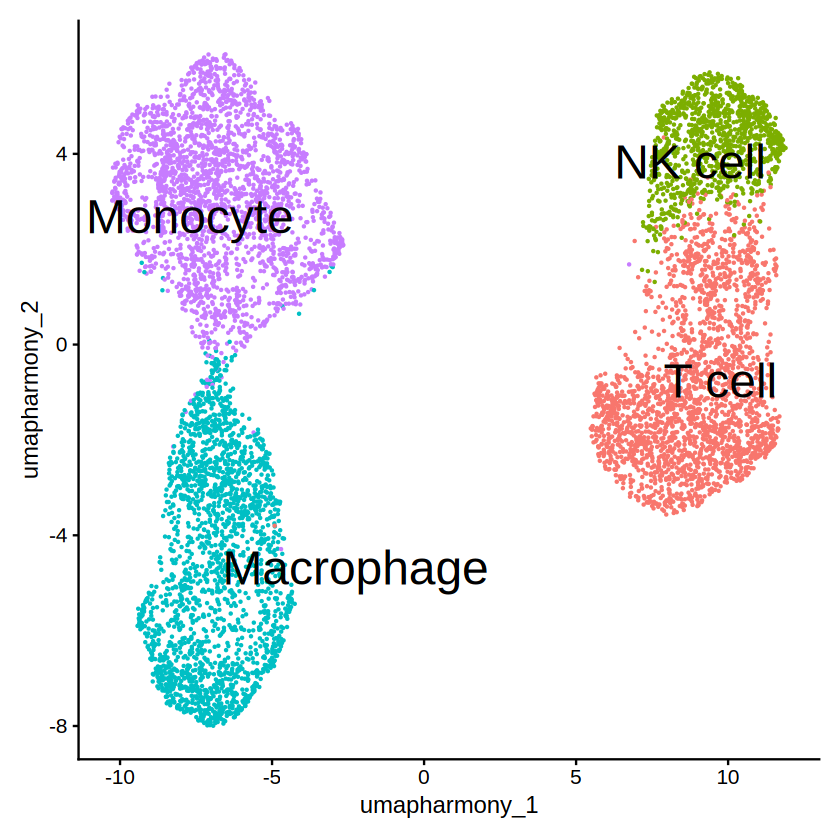

In [6]:
DimPlot(seurat, reduction = "umap.harmony", group.by = "celltype",
    label = TRUE, label.size = 10, repel = TRUE) +
    NoLegend() + ggtitle(NULL)

Since we want to draw a trajectory graph of T cells, we will subset only the T cells from the whole dataset and re-normalize.

In [7]:
seurat_t <- seurat[, seurat$celltype == "T cell"]
# normalization
seurat_t <- NormalizeData(seurat_t)

Normalizing layer: counts



In [8]:
hvg <- SelectIntegrationFeatures(
    object.list = SplitObject(seurat_t, split.by = "study"),
    assay = c("RNA", "RNA", "RNA", "RNA"),
    nfeatures = 2000, fvf.nfeatures = 2000
)
VariableFeatures(seurat_t) <- hvg

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object2 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

No variable features found for object3 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.1319”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1.0207e-16”
No variable features found for object4 in the object.list. Running FindVariableFeatures ...

Finding variable features for layer counts



### Generate CDS object

Monocle3 package uses differently structured object named cell_data_set (cds)
We recombine the normalized expressions, metadata for cells, and metadata for genes to create the cds object.

In [9]:
cds <- new_cell_data_set(
    expression_data = seurat_t@assays$RNA$data,
    cell_metadata = seurat_t@meta.data,
    gene_metadata = data.frame(
        gene_short_name = row.names(seurat_t),
        row.names = row.names(seurat_t)
        )
    )
cds

class: cell_data_set 
dim: 19354 2268 
metadata(1): cds_version
assays(1): counts
rownames(19354): A1BG A1CF ... TEC WFS1
rowData names(1): gene_short_name
colnames(2268): F01173_GCTGGGTTCCTGTAGA_haberman
  F01172_AGTAGTCGTCCGACGT_haberman ... CGTAGCGCACATTCGA_NML2_tsukui
  CTCAGAATCCTCGCAT_NML3_tsukui
colData names(10): orig.ident nCount_RNA ... celltype Size_Factor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

### Dimension reduction for CDS object

Monocle3 allows dimension reduction using hvgs. As we import normalized count in cds object, we preprocess the object without additional normalization.

In [10]:
cds <- preprocess_cds(cds, "PCA", num_dim = 30, norm_method = "none", use_genes = hvg)

We then see the explained variance of each component to select the optimal number of components to use

In [11]:
options(repr.plot.width = 7, repr.plot.height = 7)

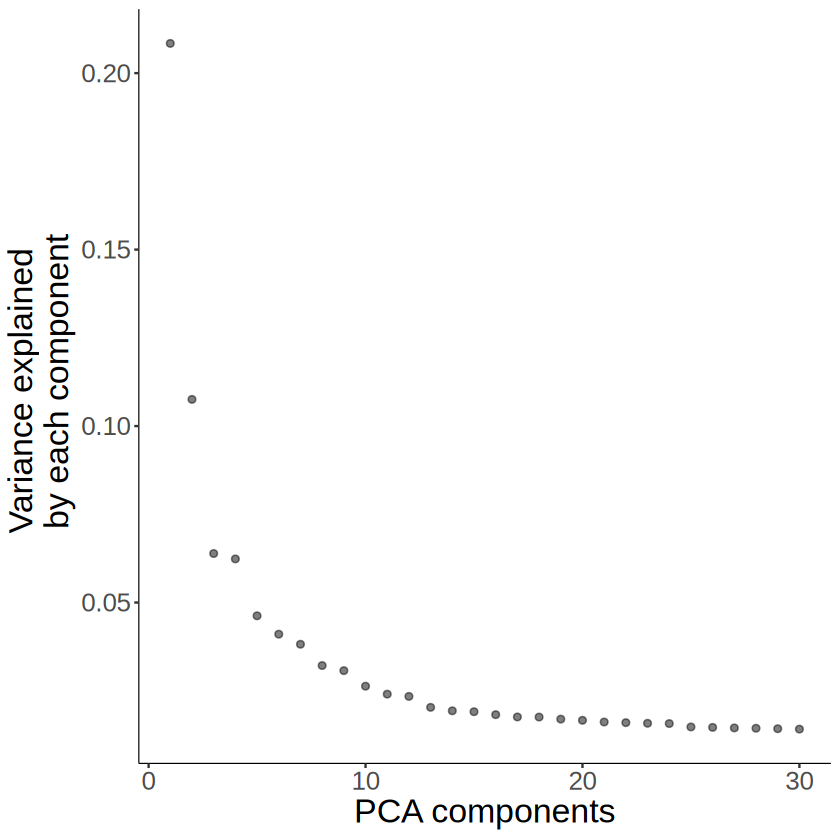

In [12]:
plot_pc_variance_explained(cds) +
    theme(
        axis.title = element_text(size = 20),
        axis.text = element_text(size = 15)
        )

In [13]:
cds <- preprocess_cds(cds, "PCA", num_dim = 10, norm_method = "none", use_genes = hvg)

### Correcting Batch effects

Since the dataset has various sample and batch effects, we perform Mutual Nearest Neighbor (MNN) batch effect correction implemented batchelor, which is included in monocle3 package.
The sample ID information is in "study" metadata.

In [14]:
options(repr.plot.width = 9, repr.plot.height = 7)

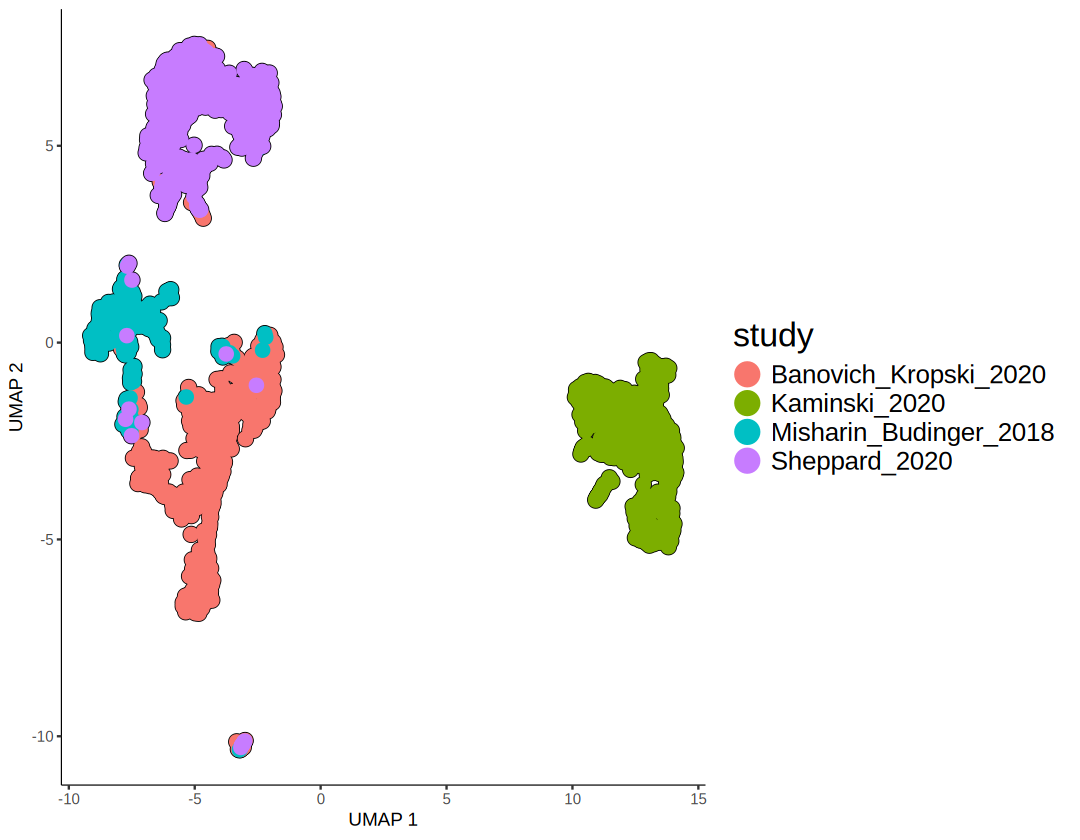

In [15]:
# before batch correction
cds <- reduce_dimension(cds, preprocess_method = "PCA")

plot_cells(cds, color_cells_by = "study",
           show_trajectory_graph = FALSE,
           label_cell_groups = FALSE,
           group_label_size = 10,
           cell_size = 1, cell_stroke = 2) +
    theme(
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 15)
        )

In [16]:
cds <- align_cds(cds, alignment_group = "study")
cds <- reduce_dimension(cds, preprocess_method = "Aligned")

Aligning cells from different batches using Batchelor.
Please remember to cite:
	 Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091



In [17]:
options(repr.plot.width = 9, repr.plot.height = 7)

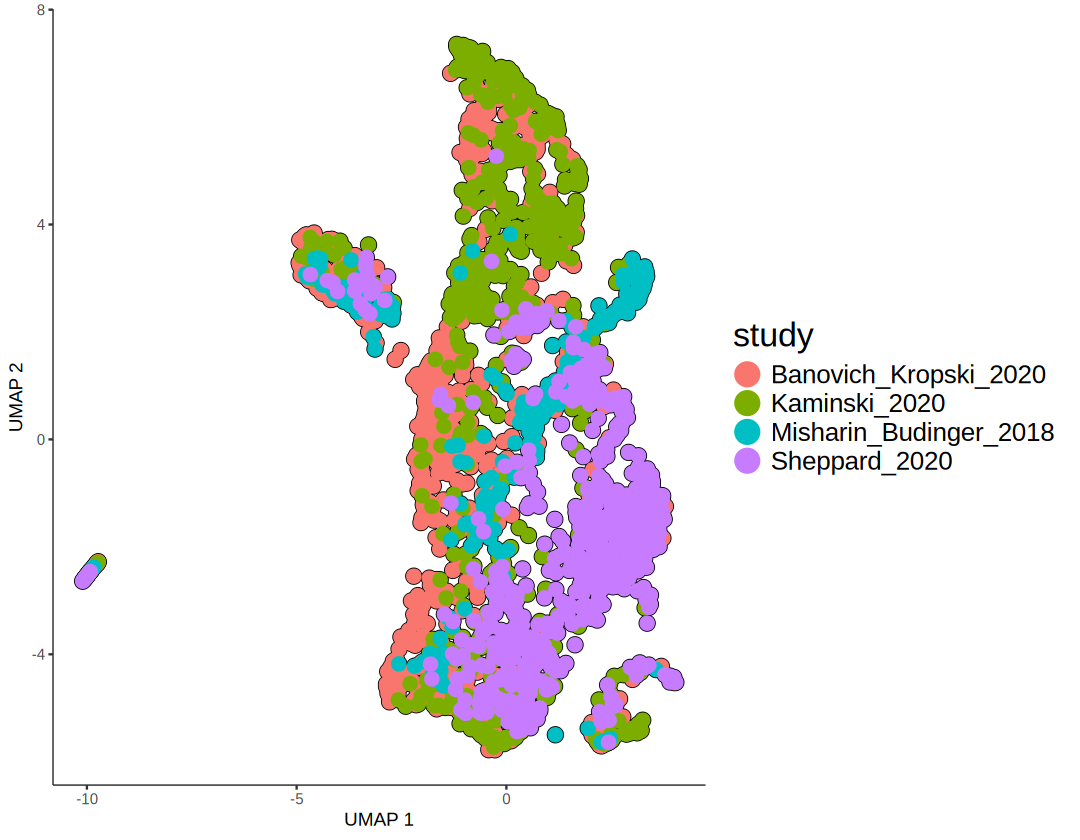

In [18]:
# after batch correction
plot_cells(cds, color_cells_by = "study",
           show_trajectory_graph = FALSE,
           label_cell_groups = FALSE,
           group_label_size = 10,
           cell_size = 1, cell_stroke = 2) +
    theme(
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 15)
        )


### Cluster cells and learn the trajectory graph

After clustering, we will fit a principal graph within each partition using the learn_graph() function.

In [19]:
options(repr.plot.width = 7, repr.plot.height = 7)

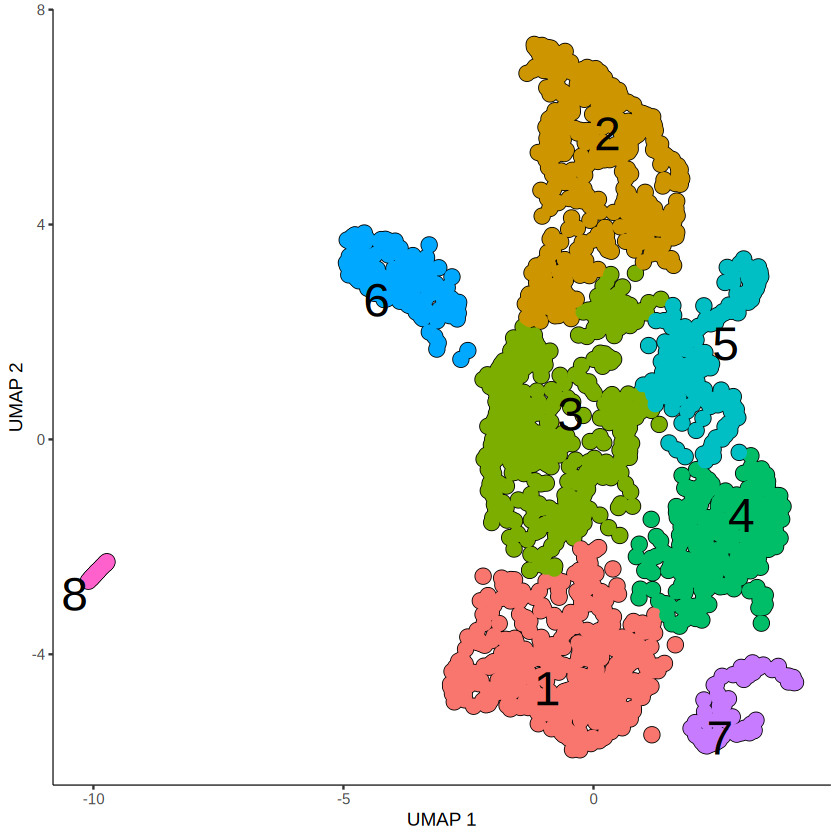

In [20]:
# clustering
cds <- cluster_cells(cds, resolution = 0.0015)

plot_cells(cds, color_cells_by = "cluster",
           show_trajectory_graph = FALSE,
           group_label_size = 10,
           cell_size = 1, cell_stroke = 2)
ggsave(paste0(OUT, "/monocle_umap-clusters.png"), width = 7, height = 7, dpi = 300)

In [21]:
# learn graph
cds = learn_graph(cds)

  |======================================================================| 100%


In [22]:
options(repr.plot.width = 8, repr.plot.height = 7)

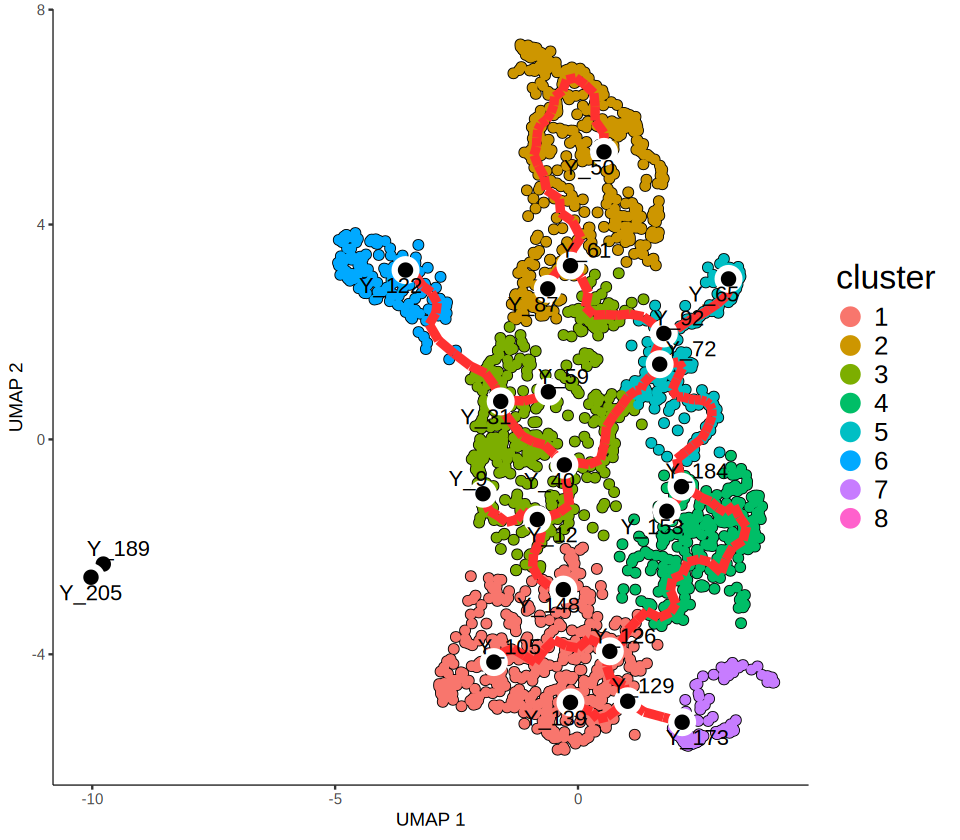

In [23]:
plot_cells(cds, color_cells_by = "cluster",
           show_trajectory_graph = TRUE,
           label_principal_points = TRUE,
           label_cell_groups = FALSE,
           graph_label_size = 3,
           trajectory_graph_color = "firebrick1", trajectory_graph_segment_size = 2,
           cell_size = 1, cell_stroke = 1
          ) +
    theme(
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 15)
    )

### Order cells in pseudotime

CCR7 and LEF1 are known as naive T cell marker, so we set the cluster where expression of these genes is high as the root state.

In [24]:
options(repr.plot.width = 10.5, repr.plot.height = 5)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


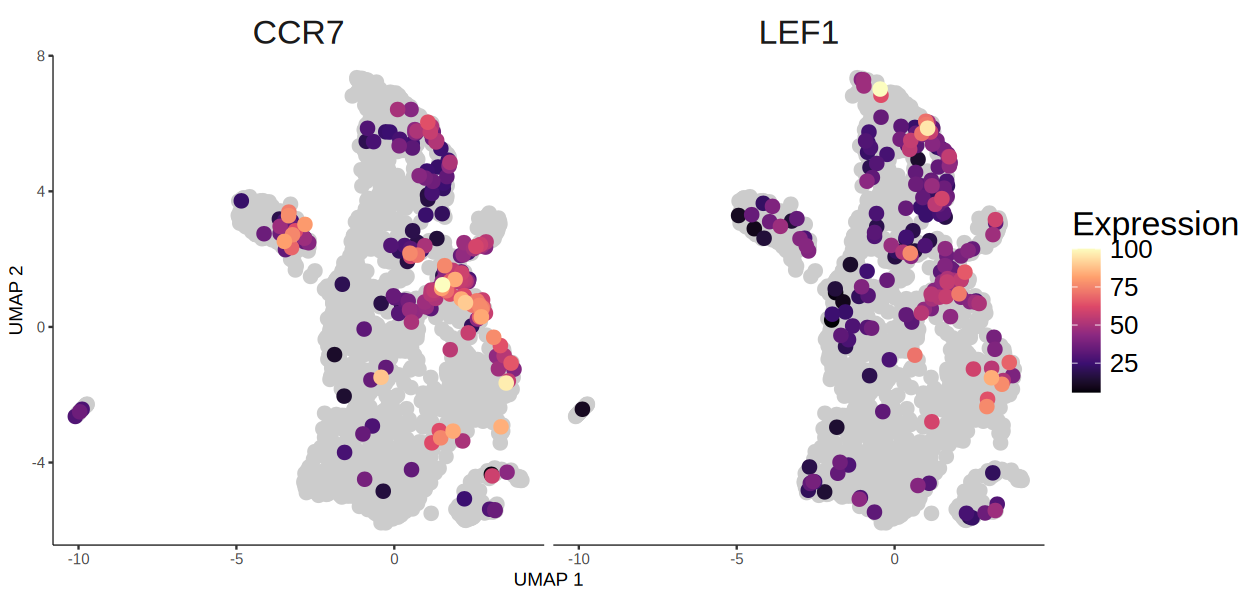

In [ ]:
plot_cells(cds, genes = c("CCR7", "LEF1"),
           show_trajectory_graph = FALSE,
           label_cell_groups = FALSE,
           graph_label_size = 3,
           cell_size = 1, cell_stroke = 2
          ) +
    labs(color = "Expression") +
    theme(
        strip.text = element_text(size = 20),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 15)
    ) +
    scale_color_viridis_c(option = "magma")

In [26]:
# order cells while setting root principal node
cds <- order_cells(cds, root_pr_nodes = "Y_72")

Plotting the cells and coloring them by pseudotime shows how they were ordered.

In [27]:
options(repr.plot.width = 8, repr.plot.height = 7)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


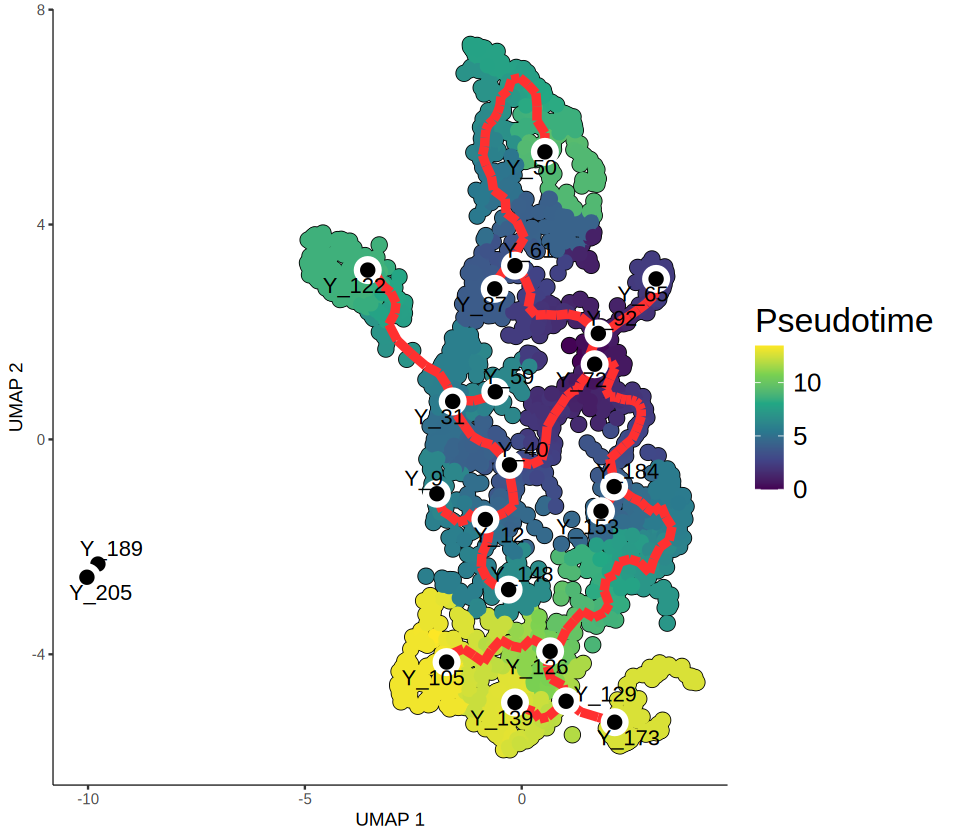

In [28]:
plot_cells(cds, color_cells_by = "pseudotime",
           show_trajectory_graph = TRUE,
           label_principal_points = TRUE, label_leaves = FALSE, label_branch_points = FALSE,
           label_cell_groups = FALSE,
           graph_label_size = 3,
           trajectory_graph_color = "firebrick1", trajectory_graph_segment_size = 2,
           cell_size = 1, cell_stroke = 2
          ) +
    labs(color = "Pseudotime") +
    theme(
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 15)
    ) +
    scale_color_viridis_c(option = "viridis")

Check the expression of genes related to t cell function.

In [29]:
options(repr.plot.width = 10.5, repr.plot.height = 5)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


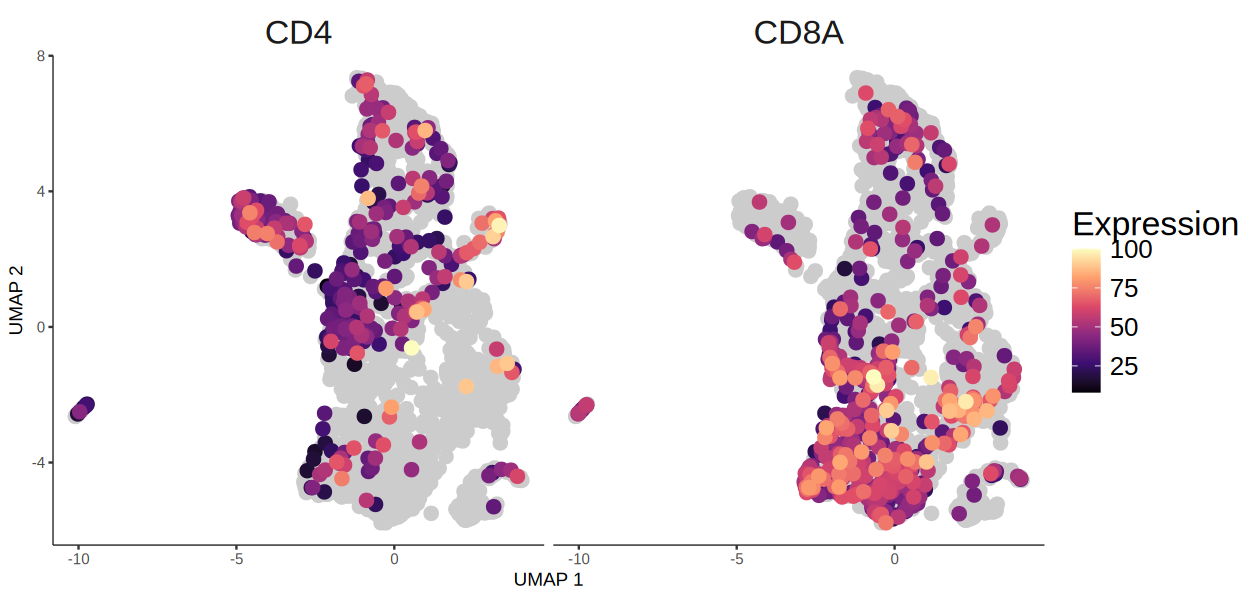

In [30]:
# CD4+ / CD8+ T cells
plot_cells(cds, genes = c("CD4", "CD8A"),
           show_trajectory_graph = FALSE,
           label_principal_points = TRUE,
           label_cell_groups = FALSE,
           graph_label_size = 3,
           cell_size = 1, cell_stroke = 2
          ) +
    labs(color = "Expression") +
    theme(
        strip.text = element_text(size = 20),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 15)
    ) +
    scale_color_viridis_c(option = "magma")

In [31]:
options(repr.plot.width = 10.5, repr.plot.height = 10)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


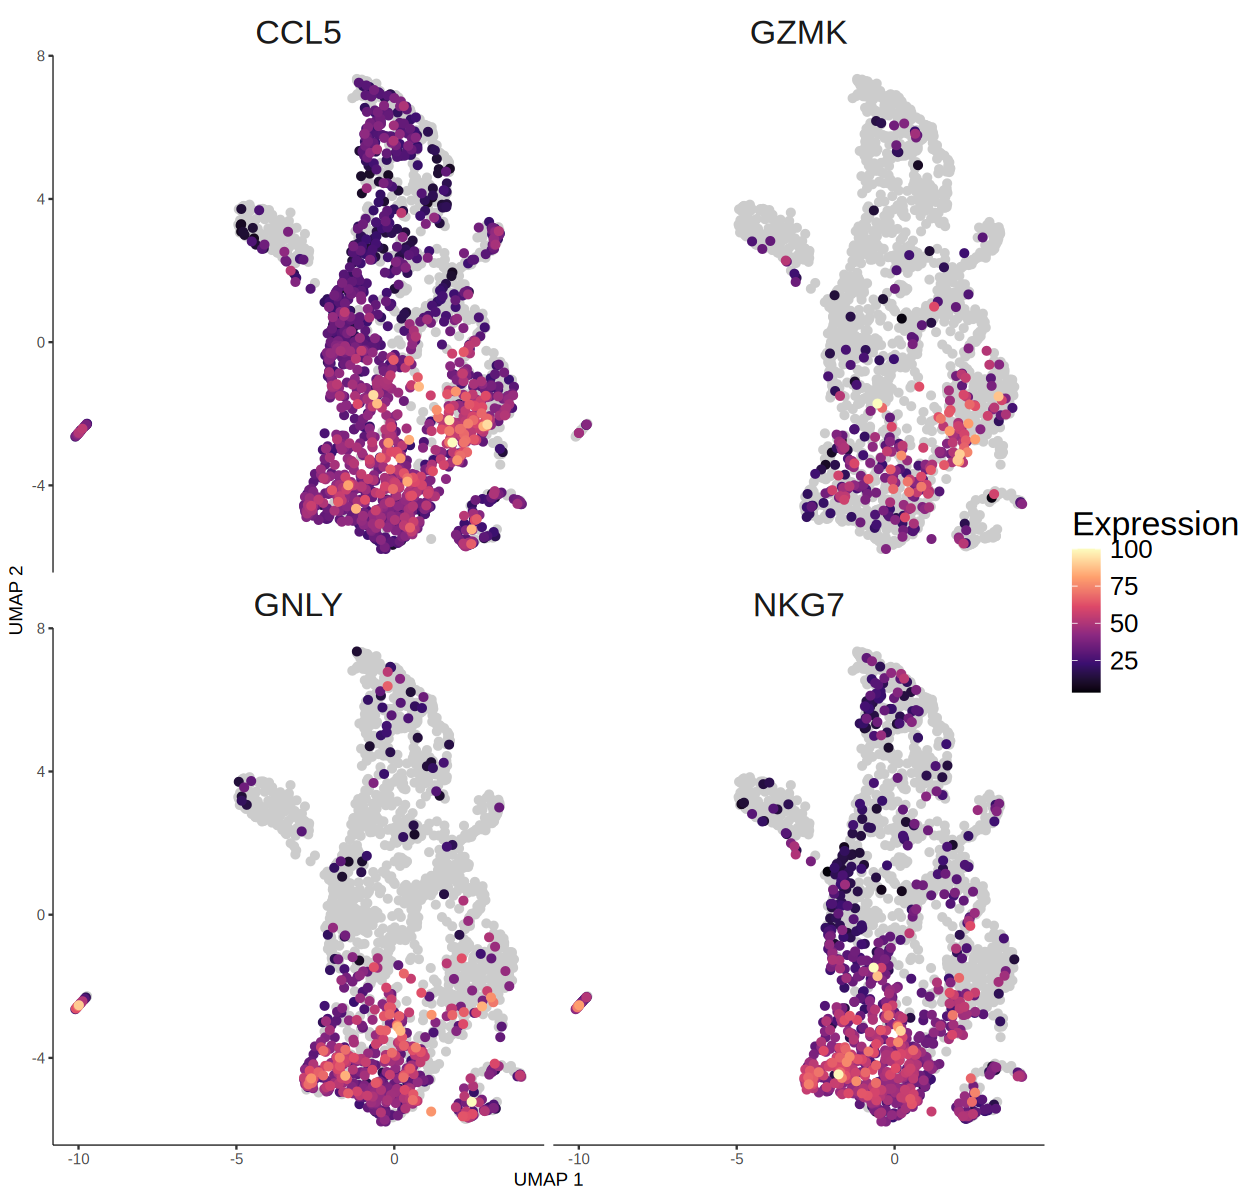

In [32]:
# Cytotoxic CD8 T cells
plot_cells(cds, genes = c("CCL5", "GZMK", "GNLY", "NKG7"),
           show_trajectory_graph = FALSE,
           label_principal_points = TRUE,
           label_cell_groups = FALSE,
           graph_label_size = 3,
           cell_size = 1, cell_stroke = 1
          ) +
    labs(color = "Expression") +
    theme(
        strip.text = element_text(size = 20),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 15)
    ) +
    scale_color_viridis_c(option = "magma")

## Reference

Butler, A., Hoffman, P., Smibert, P., Papalexi, E. & Satija, R. Integrating single-cell transcriptomic data across different conditions, technologies, and species. Nat. Biotechnol. 36, 411–420 (2018).

Cao, J. et al. The single-cell transcriptional landscape of mammalian organogenesis. Nature 566, 496–502 (2019).

Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091

L. Ma, M.O. Hernandez, Y. Zhao, M. Mehta, B. Tran, M. Kelly, Z. Rae, J.M. Hernandez, J.L. Davis, S.P. Martin, D.E. Kleiner, S.M. Hewitt, K. Ylaya, B.J. Wood, T.F. Greten, X.W. Wang. Tumor cell biodiversity drives microenvironmental reprogramming in liver cancer. Canc. Cell, 36 (4): 418-430 (2019)

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023)

In [33]:
sessionInfo()

R version 4.4.3 (2025-02-28)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 24.04.2 LTS

Matrix products: default
BLAS/LAPACK: /BiO/prog/miniforge3/envs/trajectory/lib/libopenblasp-r0.3.30.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Seoul
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] monocle3_1.4.26             SingleCellExperiment_1.28.1
 [3] SummarizedExperiment_1.36.0 GenomicRanges_1.58.0       
 [5] GenomeInfoDb_1.42.3         IRanges_2.40.1             
 [7] S4Vectors_0.44.0            Matri